<a href="https://colab.research.google.com/github/huGgW/Style-Transfer-FLYAI/blob/colab_temp/styletransfer_sw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np 
import random
import time 
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False

#Neural Style Transfer

## Objective
1. Load content image and style image. Prepare a pre-trained VGG19 model.
2. Based on the prepared model, compute the content loss and style loss using the content image and style image, respectively.
3. Based on the loss, optimize the image via gradient descent to obtain a style-transfered image.

**Connect google colab with google drive** (copy and paste the authorization code)

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Step 1: Load content image and style image

Load content and style images and plot them.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Make 'EE488/Project2/' folder in your google drive and move all the images to this directory**

In [25]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)
style_img = image_loader("/gdrive/MyDrive/EE488/Project2/starry-night.jpg")
content_img = image_loader("/gdrive/MyDrive/EE488/Project2/5.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


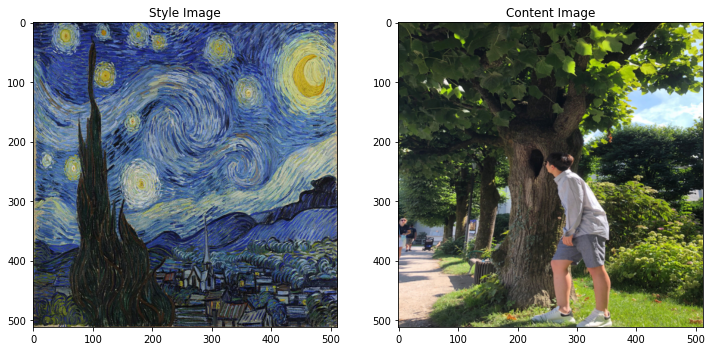

In [26]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')
plt.show()

## Step 2: Compute style loss and content loss

Here, you first need to split submodules in VGG-19 to construct content loss and style loss. Specifically, you need to store each submodule in a form of "torch.nn.modules.container.Sequential". The "Sequential" module is a container of nn.Module objects. With Sequential containers, you can stack any layer and compose them altogether. First, you should download a pre-trained VGG-19 model.



In [7]:
cnn = models.vgg19(pretrained=True).features.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

**Step 2-2:** Preparation steps

Note that the pre-trained VGG model is not updated anymore. We only update (adjust) the image. In order to use parameters in VGG11, you need to go through the following preparation steps. First, we need to **change requires_grad to False** for all weights because parameters in VGG19 won't be updated anymore. Second, we should **change in-place operation in all ReLU layers to out-of-place operation**. This is because pytorch cannot perform backpropagation for computation that includes in-place operation.


In [8]:
for name, param in cnn.named_parameters():
    param.requires_grad = False

for layer in cnn:
    if isinstance(layer, nn.ReLU):
      layer.inplace = False



**Step 2-3:** To define style loss and content loss,
After obtaining the intermediate feature of the model, you must calculate the Gram matrix.
Defines a function that obtains the output value of the intermediate layer of the model.

In [9]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

**Step 2-4:** Content loss and style loss

In [10]:
def gram_matrix(feature_map):
    _, d, h, w = feature_map.size()
    # reshape so we're multiplying the features for each channel
    feature_map = feature_map.view(d, h * w)
    
    # calculate the gram matrix
    G = torch.mm(feature_map, feature_map.t())
    return G

In [11]:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

In [12]:
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

**Step 2-5:** Obtain features for content and style image.

In [13]:
# content와 style image를 위한 feature를 얻습니다.
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}


content_features = get_features(content_img, cnn, feature_layers)
style_features = get_features(style_img, cnn, feature_layers)

In [14]:
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 512, 512])
torch.Size([1, 128, 256, 256])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 32, 32])


## Step 3: Training

Based on the content loss $J^{\text{content}}$ and style loss $J^{\text{style}}$, the overall loss is computed as the following weighted sum
\begin{equation}
J^{\text{total}} = w_c \cdot J^{\text{content}} +   w_s \cdot J^{\text{style}}
\end{equation}
where $w_c$ and $w_s$ correspond to the content weight and style weight, respectively. 

Based on the total loss, update the generated image via gradient descent and backpropagation.

In [27]:
input_img = content_img.clone()
optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
content_weight = 1e1
style_weight = 1e4
iteration = 2000           
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}
                     
for i in range(iteration):
    input_features = get_features(input_img, cnn, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) # 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()                                                      
    loss.backward()                                                            
    optimizer.step()    
    
    if i % 100 == 0:
        print("run [{}]:".format(i))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            (style_weight * style_loss).item(), (content_weight * content_loss).item()))
        print()
        
input_img.data.clamp_(0, 1)
print('train done')

run [0]:
Style Loss : 8433698.000000 Content Loss: 109.107582

run [100]:
Style Loss : 107011.625000 Content Loss: 123.145645

run [200]:
Style Loss : 39535.320312 Content Loss: 124.263474

run [300]:
Style Loss : 16644.099609 Content Loss: 124.330757

run [400]:
Style Loss : 8754.441406 Content Loss: 124.955818

run [500]:
Style Loss : 5893.910645 Content Loss: 124.963531

run [600]:
Style Loss : 4585.707031 Content Loss: 125.256615

run [700]:
Style Loss : 3669.711426 Content Loss: 125.413727

run [800]:
Style Loss : 4904.976562 Content Loss: 125.130341

run [900]:
Style Loss : 2801.732666 Content Loss: 125.638794

run [1000]:
Style Loss : 2748.155029 Content Loss: 125.466568

run [1100]:
Style Loss : 2429.625732 Content Loss: 125.900833

run [1200]:
Style Loss : 1803.600220 Content Loss: 125.686378

run [1300]:
Style Loss : 9675.221680 Content Loss: 125.497215

run [1400]:
Style Loss : 3065.736572 Content Loss: 125.944633

run [1500]:
Style Loss : 2685.166992 Content Loss: 126.23544

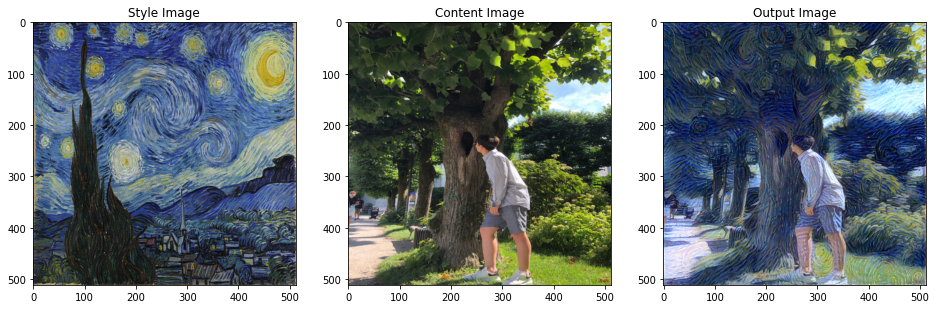

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')
plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')
plt.subplot(1, 3, 3)
imshow(input_img, title='Output Image')
plt.show()